In [1]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
from pathlib import Path
import networkx as nx

json_path = Path("../out/tracked.json")

with open(json_path, encoding='utf-8') as f:
    data = json.load(f)
    job_data = data["jobs"]
    person_data = data["persons"]

person_lookup = {person['id']: person for person in person_data}



In [2]:
def get_job_all_metadata(job_ids_str):
    job_ids = [str(job_id).strip() for job_id in str(job_ids_str).split(",")]
    metadata_list = []

    for job_id in job_ids:
        job_info = job_data.get(job_id)
        metadata_list.append(job_info)
    return metadata_list

def get_census_jobs_and_years(person_id):
    """Return list of (job, census_year) for a person, skipping null jobs."""
    result = []
    person = person_lookup.get(person_id)
    if not person:
        return result
    for entry in person.get("census_entries", []):
        job = entry.get("job")
        year = entry.get("census_year")
        result.append((job, year))
    return result


        

In [ ]:
def best_activity(metadatas):
    best_activity = 'no activity'
    best_score = 0
    best_job = 'no job'
    for meta in metadatas:
        if meta is not None:
            sector = meta.get('secteur')
            category = meta.get('catégorie')

            score = 0
            if sector:
                score += 1
            else:
                sector = 'no sector'
            if category:
                score += 1
            else:
                category = ''
            if score > best_score:
                best_score = score  # Don't forget to update the best_score!
                best_activity = sector + ' ' + category
                best_job = meta.get('job')
        
    if best_activity == 'no activity':
        for meta in metadatas:
            if meta is not None:
                job = meta.get('job')
                if job in ['rentiere', 'rentier', 'proprietaire', 'proprietaire', 'propriétaire', 'rentière', 'propriétaire']:
                    best_activity = 'propriétaire'
                    best_job = job
                    continue
                # if job in ['sans vocation']:
                #     best_activity = 'sans vocation'
                #     continue


    return best_activity, best_job


def best_year(years):
    if len(years) > 0:
        return min(years)
    else:
        return 2020

In [ ]:
def build_activity_transition_graph():
    node_weights = defaultdict(int)  # key: node name, value: weight
    edge_weights = defaultdict(int)  # key: (parent_node, child_node), value: weight
    edge_jobs = defaultdict(set)

    
    no_parents = 0
    child_no_job = 0
    parent_no_job = 0
    child_no_metadata = 0
    parent_no_metadata = 0
    child_no_activity = 0
    parent_no_activity = 0
    missing_jobs = {}

    for person in person_data:
        parent_id = person.get('parent')
        if not parent_id:
            no_parents += 1
            continue
        parent = person_lookup.get(parent_id)

        #child
        job_ids = person.get("job_ids")
        if len(job_ids) < 1:
            child_no_job += 1
            continue
        jobs_metadata = [job_data.get(str(job_id).strip()) for job_id in job_ids]
        if len(jobs_metadata) == 0:
            child_no_metadata += 1
        jobs = []
        years = []
        for entry in person.get("census_entries", []):
            jobs.append(entry.get("job"))
            years.append(entry.get("census_year"))
        child_activity, child_job = best_activity(jobs_metadata)
        if child_activity == 'no activity':
            child_no_activity += 1
            for job in jobs:
                missing_jobs[job] = missing_jobs.get(job, 0) + 1
            continue
        child_year = best_year(years)

        # parent
        parent_job_ids = parent.get("job_ids")
        if len(parent_job_ids) < 1:
            parent_no_job += 1
            continue
        parent_jobs_metadata = [job_data.get(str(job_id).strip()) for job_id in parent_job_ids]
        if len(parent_jobs_metadata) == 0:
            parent_no_metadata += 1
        parent_jobs = []
        parent_years = []
        for entry in parent.get("census_entries", []):
            parent_jobs.append(entry.get("job"))
            parent_years.append(entry.get("census_year"))
        parent_activity, parent_job = best_activity(parent_jobs_metadata)
        if parent_activity == 'no activity':
            parent_no_activity += 1
            for job in parent_jobs:
                missing_jobs[job] = missing_jobs.get(job, 0) + 1
            continue
        parent_year = best_year(parent_years)




        parent_node = f"parent: {parent_activity}"
        child_node = f"child: {child_activity}"

        # Increment node weights
        node_weights[parent_node] += 1
        node_weights[child_node] += 1

        # Increment edge weight
        edge_weights[(parent_node, child_node)] += 1
        edge_jobs[(parent_node, child_node)].add(f"{parent_job}->{child_job}")


    print(f"{len(person_data)} persons processed")
    print(no_parents, "persons with no parent")
    print(child_no_job, "children with no job")
    print(parent_no_job, "parents with no job")
    print(child_no_metadata, "children with no job metadata")
    print(parent_no_metadata, "parents with no job metadata")
    print(child_no_activity, 'children with no activty')
    print(parent_no_activity, 'parents with no activity')
    print('problematic jobs: ')
    sorted_dict = dict(sorted(missing_jobs.items(), key=lambda item: item[1], reverse=True))
    print(sorted_dict)


    
    

    # Create directed graph
    G = nx.DiGraph()

    # Add nodes with attributes
    for node, weight in node_weights.items():
        node_type = "parent" if node.startswith("parent:") else "child"
        activity = node.split(": ", 1)[1]
        G.add_node(node, type=node_type, activity=activity, weight=weight)

    # Add edges with weights
    for (parent_node, child_node), weight in edge_weights.items():
        G.add_edge(parent_node, child_node, weight=weight, jobs=edge_jobs[(parent_node, child_node)])


    return G

# Usage example:
G = build_activity_transition_graph()

# Save to GEXF file (optional)
nx.write_gexf(G, "activity_transition_graph.gexf", encoding='utf-8', prettyprint=True)






4728 persons processed
2293 persons with no parent
0 children with no job
0 parents with no job
0 children with no job metadata
0 parents with no job metadata
1724 children with no activty
158 parents with no activity
problematic jobs: 
{None: 2889, 'sans vocation': 24, 'proprietaire': 19, 'propriétaire': 17, 'employe': 13, 'relieur': 8, 'tient pension': 6, 'conducteur': 6, 'fontenier': 6, 'ecrivain': 5, 'compositeur': 5, 'coutelier': 4, 'emp . postal': 4, 'tonneur': 3, 'concierge': 3, 'feuriste': 2, 'courtepointiere': 2, 'juge': 2, 'vve de pension': 2, 'sve': 2, 'ebeniste': 2, 'marguiller': 2, 'directeur': 2, 'sans profession': 2, 'callieur|rentiere': 2, 'ligneron': 2, 'mtre macon': 2, 'compositrice': 2, 'fontainier': 2, "conseiller d'etat": 2, 'garcon de place': 1, 'piqueur': 1, 'vicher': 1, 'bordeuse': 1, 'potier': 1, 'femme de ménage': 1, 'traiteuse': 1, 'calocher': 1, 'empailleur et logeur': 1, 'ecrivain public': 1, 'secretaire aux peages': 1, 'mdessomage': 1, 'fabricant de papier

In [5]:
def graph_to_transition_matrix(G):
    """
    Given a NetworkX DiGraph G with edge weights,
    returns the transition matrix (as a numpy array)
    and the list of node labels (in matrix order).
    """
    nodes = list(G.nodes())
    n = len(nodes)
    node_index = {node: i for i, node in enumerate(nodes)}
    M = np.zeros((n, n))

    for i, src in enumerate(nodes):
        out_edges = G.out_edges(src, data='weight', default=1)
        total_weight = sum(weight for _, _, weight in out_edges)
        if total_weight > 0:
            for _, dst, weight in out_edges:
                j = node_index[dst]
                M[i, j] = weight / total_weight
        # If no outgoing edges, row remains zeros (could set self-loop if desired)

    return M, nodes


    


4728 persons processed
2293 persons with no parent
0 children with no job
0 parents with no job
0 children with no job metadata
0 parents with no job metadata
1724 children with no activty
158 parents with no activity
problematic jobs: 
{None: 2889, 'sans vocation': 24, 'proprietaire': 19, 'propriétaire': 17, 'employe': 13, 'relieur': 8, 'tient pension': 6, 'conducteur': 6, 'fontenier': 6, 'ecrivain': 5, 'compositeur': 5, 'coutelier': 4, 'emp . postal': 4, 'tonneur': 3, 'concierge': 3, 'feuriste': 2, 'courtepointiere': 2, 'juge': 2, 'vve de pension': 2, 'sve': 2, 'ebeniste': 2, 'marguiller': 2, 'directeur': 2, 'sans profession': 2, 'callieur|rentiere': 2, 'ligneron': 2, 'mtre macon': 2, 'compositrice': 2, 'fontainier': 2, "conseiller d'etat": 2, 'garcon de place': 1, 'piqueur': 1, 'vicher': 1, 'bordeuse': 1, 'potier': 1, 'femme de ménage': 1, 'traiteuse': 1, 'calocher': 1, 'empailleur et logeur': 1, 'ecrivain public': 1, 'secretaire aux peages': 1, 'mdessomage': 1, 'fabricant de papier

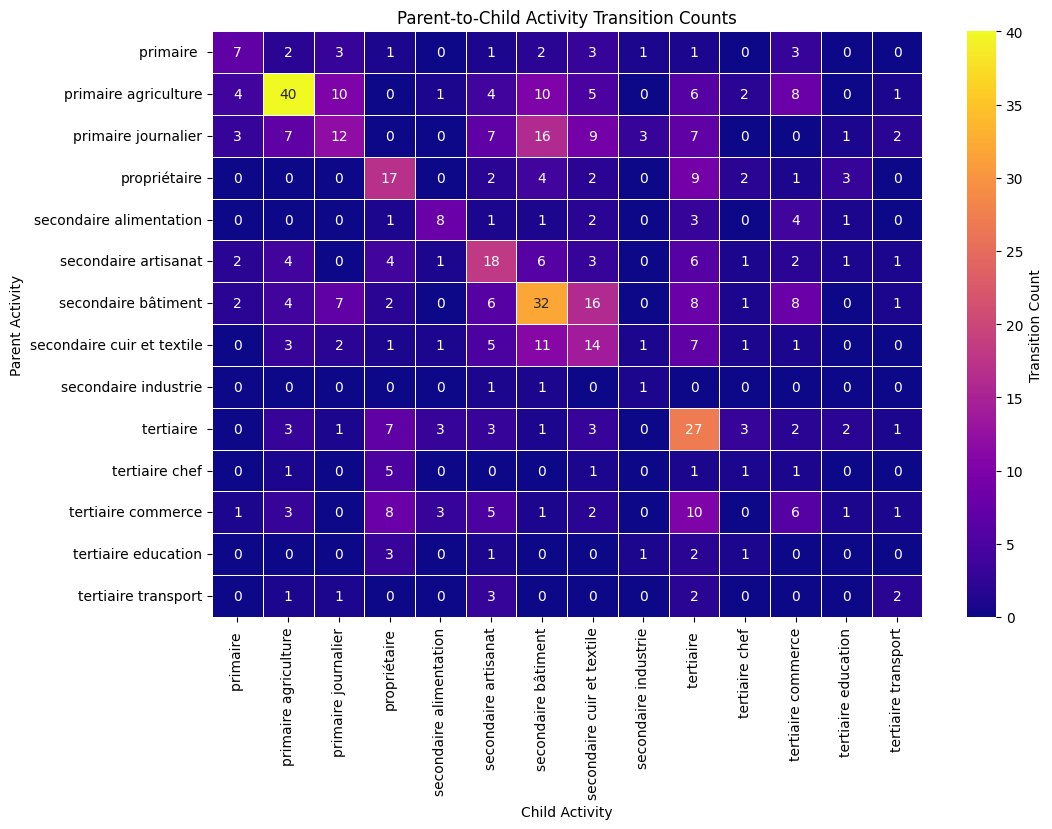

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns  # Seaborn provides better color palettes and annotation support

# Build the graph
G = build_activity_transition_graph()

# Get node order
nodes = list(G.nodes())

# Separate and sort parent and child nodes alphabetically by activity
parent_nodes = sorted([n for n in nodes if G.nodes[n]['type'] == 'parent'], key=lambda n: G.nodes[n]['activity'])
child_nodes = sorted([n for n in nodes if G.nodes[n]['type'] == 'child'], key=lambda n: G.nodes[n]['activity'])

# Get activity labels for axes
parent_labels = [G.nodes[n]['activity'] for n in parent_nodes]
child_labels = [G.nodes[n]['activity'] for n in child_nodes]

# Build the count matrix (rows: parent, columns: child)
count_matrix = np.zeros((len(parent_nodes), len(child_nodes)), dtype=int)
for i, p in enumerate(parent_nodes):
    for j, c in enumerate(child_nodes):
        if G.has_edge(p, c):
            count_matrix[i, j] = G[p][c]['weight']

# Plot the count matrix as a heatmap with annotations and a multicolor palette
plt.figure(figsize=(max(8, len(child_labels)*0.8), max(6, len(parent_labels)*0.6)))
sns.heatmap(
    count_matrix,
    annot=True,           # Show counts in each cell
    fmt="d",              # Integer format for counts
    cmap="plasma",       # Multicolor palette (alternatives: 'plasma', 'magma', 'coolwarm', 'Spectral')
    linewidths=0.5,       # Optional: grid lines between cells
    xticklabels=child_labels,
    yticklabels=parent_labels,
    cbar_kws={'label': 'Transition Count'}
)
plt.xlabel('Child Activity')
plt.ylabel('Parent Activity')
plt.title('Parent-to-Child Activity Transition Counts')
plt.tight_layout()
plt.show()




4728 persons processed
2293 persons with no parent
0 children with no job
0 parents with no job
0 children with no job metadata
0 parents with no job metadata
1724 children with no activty
158 parents with no activity
problematic jobs: 
{None: 2889, 'sans vocation': 24, 'proprietaire': 19, 'propriétaire': 17, 'employe': 13, 'relieur': 8, 'tient pension': 6, 'conducteur': 6, 'fontenier': 6, 'ecrivain': 5, 'compositeur': 5, 'coutelier': 4, 'emp . postal': 4, 'tonneur': 3, 'concierge': 3, 'feuriste': 2, 'courtepointiere': 2, 'juge': 2, 'vve de pension': 2, 'sve': 2, 'ebeniste': 2, 'marguiller': 2, 'directeur': 2, 'sans profession': 2, 'callieur|rentiere': 2, 'ligneron': 2, 'mtre macon': 2, 'compositrice': 2, 'fontainier': 2, "conseiller d'etat": 2, 'garcon de place': 1, 'piqueur': 1, 'vicher': 1, 'bordeuse': 1, 'potier': 1, 'femme de ménage': 1, 'traiteuse': 1, 'calocher': 1, 'empailleur et logeur': 1, 'ecrivain public': 1, 'secretaire aux peages': 1, 'mdessomage': 1, 'fabricant de papier

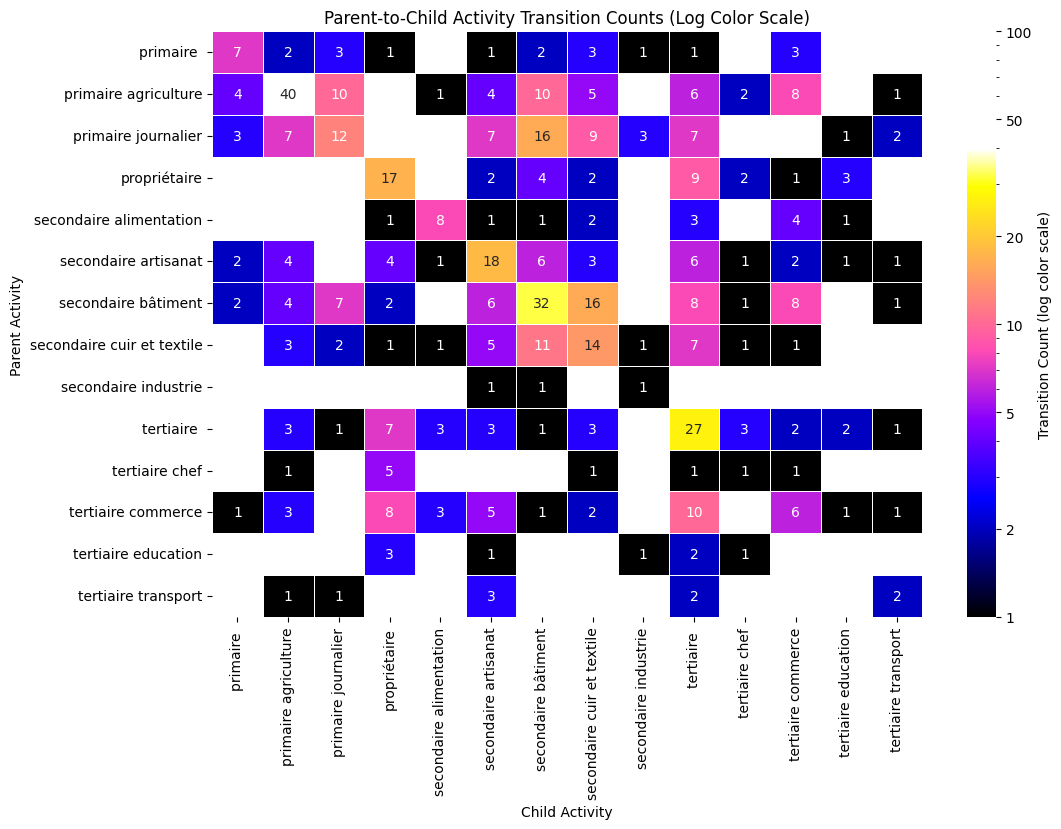

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.colors import LogNorm
from matplotlib.ticker import FuncFormatter

# Build the graph
G = build_activity_transition_graph()

# Get node order
nodes = list(G.nodes())

# Separate and sort parent and child nodes alphabetically by activity
parent_nodes = sorted([n for n in nodes if G.nodes[n]['type'] == 'parent'], key=lambda n: G.nodes[n]['activity'])
child_nodes = sorted([n for n in nodes if G.nodes[n]['type'] == 'child'], key=lambda n: G.nodes[n]['activity'])

# Get activity labels for axes
parent_labels = [G.nodes[n]['activity'] for n in parent_nodes]
child_labels = [G.nodes[n]['activity'] for n in child_nodes]

# Build the count matrix (rows: parent, columns: child)
count_matrix = np.zeros((len(parent_nodes), len(child_nodes)), dtype=int)
for i, p in enumerate(parent_nodes):
    for j, c in enumerate(child_nodes):
        if G.has_edge(p, c):
            count_matrix[i, j] = G[p][c]['weight']

# Mask zeros to avoid log(0) issues in LogNorm
masked_matrix = np.ma.masked_where(count_matrix == 0, count_matrix)

plt.figure(figsize=(max(8, len(child_labels)*0.8), max(6, len(parent_labels)*0.6)))
ax = sns.heatmap(
    masked_matrix,
    annot=True,
    fmt="d",
    cmap="gnuplot2",  # or viridis, Spectral, magma, plasma, nipy_spectral, gist_yarg, gist_ncar, gnuplot2
    norm=LogNorm(vmin=1, vmax=count_matrix.max()),
    linewidths=0.5,
    xticklabels=child_labels,
    yticklabels=parent_labels,
    cbar_kws={'label': 'Transition Count (log color scale)'}
)

# Format the colorbar to show integer tick labels
colorbar = ax.collections[0].colorbar
colorbar.set_ticks([1, 2, 5, 10, 20, 50, 100])  # Choose ticks that make sense for your data
colorbar.set_ticklabels([str(int(t)) for t in colorbar.get_ticks()])

plt.xlabel('Child Activity')
plt.ylabel('Parent Activity')
plt.title('Parent-to-Child Activity Transition Counts (Log Color Scale)')
plt.tight_layout()
plt.show()


4728 persons processed
2293 persons with no parent
0 children with no job
0 parents with no job
0 children with no job metadata
0 parents with no job metadata
1724 children with no activty
158 parents with no activity
problematic jobs: 
{None: 2889, 'sans vocation': 24, 'proprietaire': 19, 'propriétaire': 17, 'employe': 13, 'relieur': 8, 'tient pension': 6, 'conducteur': 6, 'fontenier': 6, 'ecrivain': 5, 'compositeur': 5, 'coutelier': 4, 'emp . postal': 4, 'tonneur': 3, 'concierge': 3, 'feuriste': 2, 'courtepointiere': 2, 'juge': 2, 'vve de pension': 2, 'sve': 2, 'ebeniste': 2, 'marguiller': 2, 'directeur': 2, 'sans profession': 2, 'callieur|rentiere': 2, 'ligneron': 2, 'mtre macon': 2, 'compositrice': 2, 'fontainier': 2, "conseiller d'etat": 2, 'garcon de place': 1, 'piqueur': 1, 'vicher': 1, 'bordeuse': 1, 'potier': 1, 'femme de ménage': 1, 'traiteuse': 1, 'calocher': 1, 'empailleur et logeur': 1, 'ecrivain public': 1, 'secretaire aux peages': 1, 'mdessomage': 1, 'fabricant de papier

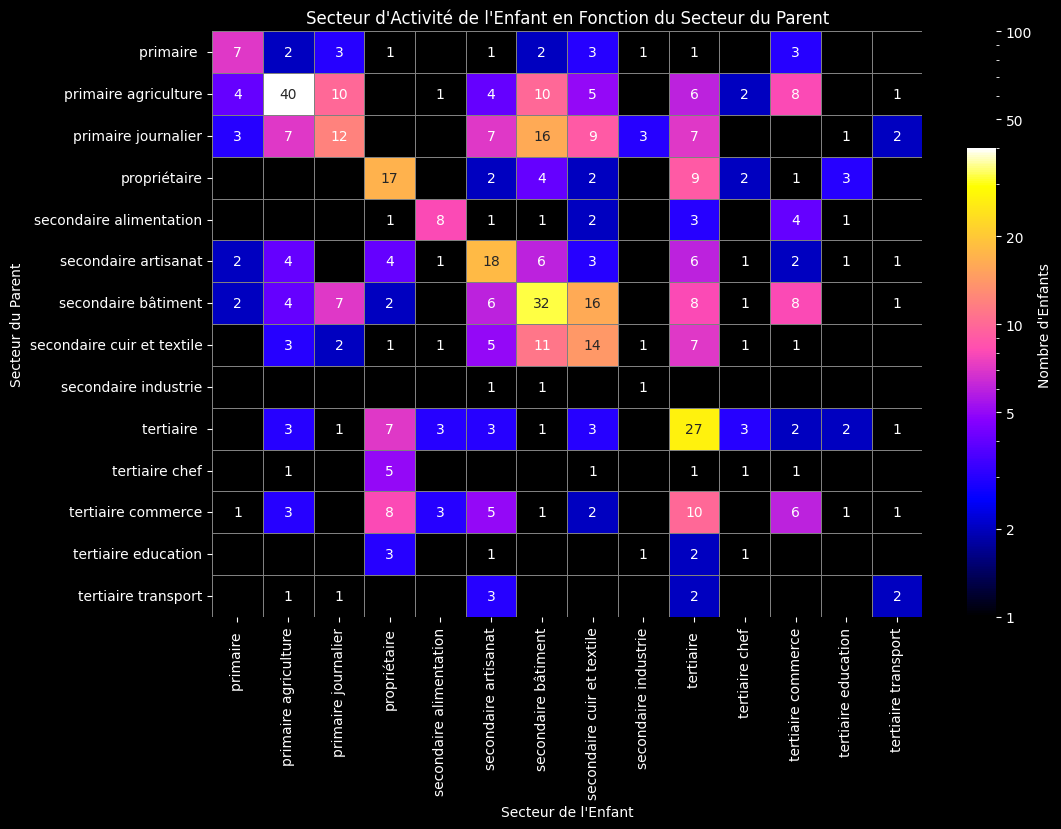

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.colors import LogNorm

# Build the graph
G = build_activity_transition_graph()

# Get node order
nodes = list(G.nodes())

# Separate and sort parent and child nodes alphabetically by activity
parent_nodes = sorted([n for n in nodes if G.nodes[n]['type'] == 'parent'], key=lambda n: G.nodes[n]['activity'])
child_nodes = sorted([n for n in nodes if G.nodes[n]['type'] == 'child'], key=lambda n: G.nodes[n]['activity'])

# Get activity labels for axes
parent_labels = [G.nodes[n]['activity'] for n in parent_nodes]
child_labels = [G.nodes[n]['activity'] for n in child_nodes]

# Build the count matrix (rows: parent, columns: child)
count_matrix = np.zeros((len(parent_nodes), len(child_nodes)), dtype=int)
for i, p in enumerate(parent_nodes):
    for j, c in enumerate(child_nodes):
        if G.has_edge(p, c):
            count_matrix[i, j] = G[p][c]['weight']

# Mask zeros to avoid log(0) issues in LogNorm
masked_matrix = np.ma.masked_where(count_matrix == 0, count_matrix)

# Create annotation matrix with empty string for zeros
annot_matrix = np.where(count_matrix == 0, "", count_matrix)

# Set up black background
plt.style.use('dark_background')
fig, ax = plt.subplots(figsize=(max(8, len(child_labels)*0.8), max(6, len(parent_labels)*0.6)))
fig.patch.set_facecolor('black')
ax.set_facecolor('black')

# Draw heatmap with gray grid lines
sns.heatmap(
    masked_matrix,
    annot=annot_matrix,
    fmt="",
    cmap="gnuplot2",  # or another colormap you prefer
    norm=LogNorm(vmin=1, vmax=count_matrix.max()),
    linewidths=0.5,
    linecolor='gray',  # <-- set grid lines to gray
    xticklabels=child_labels,
    yticklabels=parent_labels,
    cbar=True,
    cbar_kws={'label': "Nombre d'Enfants"}
)

# Set all text, ticks, and spines to white
ax.tick_params(axis='both', colors='white')
ax.xaxis.label.set_color('white')
ax.yaxis.label.set_color('white')
ax.title.set_color('white')
for spine in ax.spines.values():
    spine.set_edgecolor('white')

# Annotate the colorbar
colorbar = ax.collections[0].colorbar
colorbar.ax.yaxis.set_tick_params(color='white')
plt.setp(colorbar.ax.yaxis.get_ticklabels(), color='white')
colorbar.set_ticks([1, 2, 5, 10, 20, 50, 100])
colorbar.set_ticklabels([str(int(t)) for t in colorbar.get_ticks()])

plt.xlabel("Secteur de l'Enfant")
plt.ylabel('Secteur du Parent')
plt.title("Secteur d'Activité de l'Enfant en Fonction du Secteur du Parent")
plt.tight_layout()
plt.show()
